# Experimentation of Detecting Phishing Links 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input,
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
)
from tensorflow.keras.models import Model

import os
import requests
import zipfile
import os

## Datasets

- https://data.mendeley.com/datasets/vfszbj9b36/1
- https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset
- https://www.kaggle.com/datasets/harisudhan411/phishing-and-legitimate-urls
- https://www.kaggle.com/datasets/taruntiwarihp/phishing-site-urls
- https://www.kaggle.com/datasets/joebeachcapital/phishing-urls
- https://www.kaggle.com/datasets/shashwatwork/web-page-phishing-detection-dataset

In [2]:
phishing_df = pd.read_csv("dataset/phishing_data_num_1.csv")
phishing_df = phishing_df[["URL", "label"]]


phishing_df2 = pd.read_csv("dataset/dataset_num_2.csv")
phishing_df2["type"] = phishing_df2["type"].apply(
    lambda x: 0 if x == "legitimate" else 1
)
phishing_df2.columns = ['URL', 'label']


phishing_df3 = pd.read_csv("dataset/dataset_num_3.csv")
phishing_df3.columns = ["URL", "label"]


phishing_df4 = pd.read_csv("dataset/phishing_data_num_4.csv")
phishing_df4.columns = ["URL", "label"]
phishing_df4["label"] = phishing_df4["label"].apply(
    lambda x: 1 if x == "bad" else 0
)
phishing_df4_bad = phishing_df4[phishing_df4['label'] == 1]


phishing_df5 = pd.read_csv(
    "dataset/dataset_num 5.csv", encoding="ISO-8859-1", on_bad_lines="skip"
)
phishing_df5 = phishing_df5[['domain', 'label']].dropna()
phishing_df5.columns = ["URL", "label"]
phishing_df5["label"] = phishing_df5["label"].astype(int)


phishing_df6 = pd.read_csv("dataset/dataset_phishing num 6.csv")
phishing_df6 = phishing_df6[['url', 'status']]
phishing_df6.columns = ["URL", "label"]
phishing_df6["label"] = phishing_df6["label"].apply(
    lambda x: 1 if x == "phishing" else 0
)

C:\Users\lelop\AppData\Local\Temp\ipykernel_8204\1400040877.py:24: DtypeWarning: Columns (1,2,3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  phishing_df5 = pd.read_csv(


In [3]:
df = pd.concat(
    [
        phishing_df,
        phishing_df2,
        phishing_df3,
        phishing_df4_bad,
        phishing_df5,
        phishing_df6,
    ],
    ignore_index=True,
)

In [4]:
df = df.drop_duplicates(subset="URL", keep="last")

In [5]:
len(df)

1481551

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1481551 entries, 0 to 1771745
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   URL     1481551 non-null  object
 1   label   1481551 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 33.9+ MB


## Data Exploration

In [7]:
df_label_count = df.groupby(by="label").count()
df_label_count.index = ['Non-Phishing', 'Phishing']

total_count = df_label_count.sum()
check_label_counts_percentage = (df_label_count / total_count) * 100
check_label_counts_percentage.columns = ['Label Percentage']
check_label_counts_percentage.apply(round)

,Label Percentage
Non-Phishing,51.0
Phishing,49.0


In [8]:
# How many url contains protocals in the string
df_http = df['URL'].str.contains('://', na=False)
df_http.sum()

contains_http = (df_http.sum() / len(df_http)) * 100
does_not_contain_http = 100 - contains_http

print(f"Num of rows that contains the protocal in the URL is: {contains_http:.0f}%")
print(f"Num of rows that does not contain the protocal in the URL is: {does_not_contain_http:.0f}%")

Num of rows that contains the protocal in the URL is: 59%
Num of rows that does not contain the protocal in the URL is: 41%


In [ ]:
protocal_regex = r'^(?=.{0,10}://).*?://'

In [ ]:
df[df['URL'].str.contains(protocal_regex, na=False)].head()

,URL,label
0,https://www.southbankmosaics.com,1
1,https://www.uni-mainz.de,1
2,https://www.voicefmradio.co.uk,1
3,https://www.sfnmjournal.com,1
4,https://www.rewildingargentina.org,1


In [ ]:
df[~df['URL'].str.contains(protocal_regex, na=False)].head()

,URL,label
685971,0000111servicehelpdesk.godaddysites.com,0
685972,000011accesswebform.godaddysites.com,0
685973,00003.online,0
685974,0009servicedeskowa.godaddysites.com,0
685975,000n38p.wcomhost.com,0


## Data Cleaning

In [ ]:
# Remove the first :// in the string within the first 10 characters of the string
# df['URL'] = df['URL'].str.replace(protocal_regex, '', regex=True)
# df['URL'] = df['URL'].str.replace(protocal_regex, '', regex=True)

In [13]:
df[df['URL'].str.contains(protocal_regex, na=False)].head()

,URL,label


## Train Test Split

In [14]:
X = df['URL']
y = df['label']

In [15]:
def dataset_spliter(experimenting_with_model: bool):
    if experimenting_with_model:
        X_trunc, _ , y_trunc, _ = train_test_split(X, y, 
                                                  test_size=0.90, random_state=4, 
                                                  stratify=y, shuffle=True)
        return train_test_split(X_trunc, y_trunc, test_size=0.3, random_state=4, stratify=y_trunc, shuffle=True)
    else:
        return train_test_split(X, y, test_size=0.84, random_state=4, stratify=y,shuffle=True)

In [16]:
X_train, X_test, y_train, y_test = dataset_spliter(experimenting_with_model=False)

In [17]:
print(f"Training set: {len(X_train)}")
print(f"Testing set: {len(X_test)}")

Training set: 237048
Testing set: 1244503


## Data Preprocessing

In [18]:
# Initialize tokenizer with an OOV token.
tokenizer = Tokenizer(char_level=True, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1  # plus one for padding token
sequences = tokenizer.texts_to_sequences(X_train)
max_length = max(len(seq) for seq in sequences)

In [19]:
def convert_url_padding(data):
    # Convert URLs to sequences and pad them
    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="post")
    return padded_sequences

In [20]:
X_train_encoding = convert_url_padding(X_train)
X_test_encoding = convert_url_padding(X_test)

## Tensorflow Callbacks

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitors validation loss
    patience=2,  # Stops if loss doesn't improve for 5 epochs
    restore_best_weights=True,  # Restores model to best weights when stopped
    verbose=1,
)

## CNN Model

In [22]:
def create_cnn_model(vocab_size, embedding_dim, input_length):
    inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length, mask_zero=True)(inputs)

    # A 1D convolution layer to capture n-gram features
    x = Conv1D(filters=128, kernel_size=7, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)

    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    # Binary classification output
    output_class = Dense(1, activation='sigmoid', name='binary_class')(x)
    model = Model(inputs, output_class)
    return model

# Create the CNN model
embedding_dim = 256  # You can experiment with this size
cnn_model = create_cnn_model(vocab_size, embedding_dim, input_length=max_length)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# cnn_model.summary()

## Training

In [23]:
history_cnn = cnn_model.fit(
    X_train_encoding,
    y_train,
    epochs=5,
    validation_split=0.3,
    batch_size=64,
    callbacks=[early_stopping],
)

Epoch 1/5
2593/2593 [==============================] - 87s 30ms/step - loss: 0.3021 - accuracy: 0.8874 - val_loss: 0.2541 - val_accuracy: 0.9061
Epoch 2/5
2593/2593 [==============================] - 77s 30ms/step - loss: 0.2458 - accuracy: 0.9082 - val_loss: 0.2323 - val_accuracy: 0.9094
Epoch 3/5
2593/2593 [==============================] - 78s 30ms/step - loss: 0.2247 - accuracy: 0.9146 - val_loss: 0.2401 - val_accuracy: 0.9080
Epoch 4/5
2593/2593 [==============================] - 77s 30ms/step - loss: 0.2100 - accuracy: 0.9196 - val_loss: 0.2377 - val_accuracy: 0.9080
Epoch 4: early stopping


## Evaluation

In [24]:
y_pred = cnn_model.predict(X_test_encoding)

38891/38891 [==============================] - 191s 5ms/step


In [25]:
y_pred_int = (y_pred > 0.5).astype(int)

In [26]:
def accuracy_and_confusion_matrix(y_test, y_pred):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Precision is: {precision}")
    print(f"Recall is: {recall}")
    print(f"F1 Score is: {f1}")
    print(f"Accuracy is: {accuracy}")
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Safe", "Phishing"],
        yticklabels=["Safe", "Phishing"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

Precision is: 0.8885546384197938
Recall is: 0.9325762214494495
F1 Score is: 0.9100333704832277
Accuracy is: 0.9102276169683802


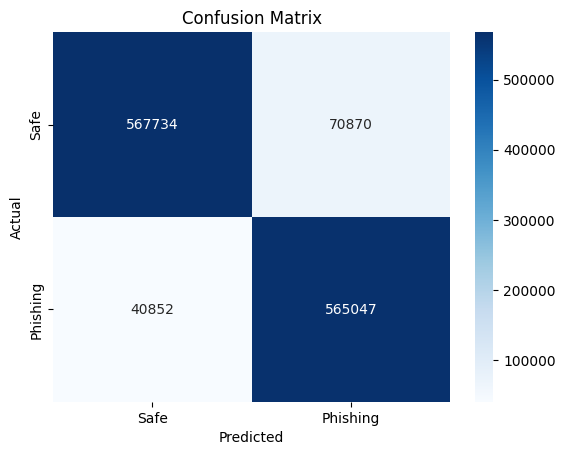

In [27]:
accuracy_and_confusion_matrix(y_test, y_pred_int)

In [28]:
df_errors = pd.DataFrame({
    "URL": X_test,
    "label": y_test,
    "Prediction": y_pred_int.squeeze()
})

df_errors.head()

,URL,label,Prediction
1207251,fanforum.com/f251/,1,1
437174,www.freecodesource.com/album-covers/B0042X90LG...,0,0
98504,www.wikileaks.org,1,1
421767,www.facebook.com/glenn.sugita,0,0
800023,khggf.ll9fve717.cn,0,0


In [29]:
df_errors[ df_errors['label'] != df_errors['Prediction']]

,URL,label,Prediction
1762241,promocao-oboticario.web.app/,1,0
147475,tide-electronics.com/lp_creditare/portal/clien...,0,1
1388489,www.newworldencyclopedia.org/entry/Computed_to...,1,0
46011,taplink.cc/yahoomaill0,0,1
580174,puravidacreategood.com/,0,1
...,...,...,...
1755248,richard_wilding.tripod.com/monopoly.htm,0,1
1415938,paciflcbasin.harbeletric.com/dos/GDrive/source...,0,1
1425730,absoluteerp.in/fatura/conta/Inovar/,0,1
66601,www.mail.jobsout.com,0,1
